# Preprocessing

**Imports**

In [3]:
import os
import glob
import csv
import numpy as np
from cv2 import cv2 
import numpy as np 
import pandas as pd
import xml.etree.ElementTree as et
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from skimage import data, exposure
# from tqdm import tqdm
from PIL import Image

 ### 1. Convert all xml files into one csv file containing all the data 

In [4]:
def xmls_to_csv(xmls_dir, csv_filename):
    xml_list = []
    xmls_dir = os.path.join(os.getcwd(), xmls_dir)
    
    for xml_file in glob.glob(xmls_dir + '/*.xml'):
        tree = et.parse(xml_file)
        root = tree.getroot()
        value = (
            int(root.find('ObservationId').text),
            int(root.find('MediaId').text),
            float(root.find('Vote').text),
            root.find('Content').text,
            int(root.find('ClassId').text),
            root.find('Family').text,
            root.find('Genus').text,
            root.find('Species').text,
            root.find('Location').text,
            root.find('Date').text
        )
        
        xml_list.append(value)
        
    columns = [
        'ObservationId',
        'MediaId',
        'Vote',
        'Content',
        'ClassId',
        'Family',
        'Genus',
        'Species',
        'Location',
        'Date'
    ]
    
    df = pd.DataFrame(xml_list, columns=columns)
    df.to_csv(csv_filename, index=None) 

In [5]:
print('Converting xml files...')
xmls_to_csv('small_dataset_train/train', 'Flowers.csv')
print('Successfully converted the xml files to csv.')

Converting xml files...
Successfully converted the xml files to csv.


#### Analyze the flowers repartition by species

In [6]:
def group_flowers_species():
    with open('Flowers.csv', mode='r') as csv_file:
        grouped_flowers = {}
        nb_flowers = 0
        flowers = csv.DictReader(csv_file)

        for flower in flowers:
            nb_flowers += 1
            species = flower["Species"]
            if species in grouped_flowers:
                grouped_flowers[species].append(flower["MediaId"])
            else:
                grouped_flowers[species] = [flower["MediaId"]]
    
        # Print number of flowers by species
        for species in grouped_flowers:
            print(species, ":", len(grouped_flowers[species]))            
        
        print("\n", len(grouped_flowers), "species,", nb_flowers, "flowers")

In [7]:
group_flowers_species()

Hypochaeris radicata L. : 84
Ophrys virescens Philippe : 55
Ficaria verna Huds. : 77
Salix caprea L. : 88
Aconitum napellus L. : 61
Tulipa sylvestris L. : 66
Orchis purpurea Huds. : 94
Orchis anthropophora (L.) All. : 56
Epipactis helleborine (L.) Crantz : 68
Aquilegia vulgaris L. : 75
Cichorium intybus L. : 109
Glaucium flavum Crantz : 74
Dactylorhiza fuchsii (Druce) Soó : 54
Anemone nemorosa L. : 55
Orchis mascula (L.) L. : 74
Ilex aquifolium L. : 51
Cyanus segetum Hill : 65
Ophrys aranifera Huds. : 83
Chelidonium majus L. : 60
Ophrys lutea Cav. : 68
Cistus albidus L. : 69
Papaver rhoeas L. : 119
Astrantia major L. : 56
Ophrys apifera Huds. : 108
Ophrys scolopax Cav. : 90
Anacamptis morio (L.) R.M.Bateman, Pridgeon & M.W.Chase : 49
Achillea millefolium L. : 62
Centaurea aspera L. : 65
Daucus carota L. : 95
Primula vulgaris Huds. : 56
Urospermum dalechampii (L.) Scop. ex F.W.Schmidt : 70
Cirsium vulgare (Savi) Ten. : 58
Epipactis atrorubens (Hoffm.) Besser : 48
Anacamptis pyramidalis 

In [8]:
df = pd.read_csv('Flowers.csv')
df = df.sort_values(['MediaId'], ascending=True)
df.head()

,ObservationId,MediaId,Vote,Content,ClassId,Family,Genus,Species,Location,Date
3334,3087,23,2.0,Flower,5148,Salicaceae,Salix,Salix caprea L.,Champ-sur-Drac,2006-3-10
400,664,133,4.0,Flower,576,Asteraceae,Cyanus,Cyanus segetum Hill,Paris,2013-6-28
2415,33480,177,3.0,Flower,30471,Orchidaceae,Ophrys,Ophrys scolopax Cav.,Lauret,2009-5-20
3189,4130,194,4.0,Flower,1047,Asteraceae,Leucanthemum,Leucanthemum vulgare Lam.,NaN,2013-6-27
2149,5260,281,4.0,Flower,8600,Orchidaceae,Anacamptis,Anacamptis pyramidalis (L.) Rich.,La Tour-sur-Orb,2013-5-21


## 2. Link images with their associated data

#### ***Put images into an array***

In [9]:
# function to load folder into arrays and then it returns that same array
def loadImages():
    # Put files into lists and return them as one list of size 4
    image_path = os.path.join(os.getcwd(), 'small_dataset_train/train')
    image_files = [os.path.join(image_path, file)
         for file in os.listdir(image_path) if file.endswith('.jpg')]
    
    return image_files

In [10]:
def reloadImages():
    images = []
    image_files = sorted([os.path.join('small_dataset_train/train', file)
         for file in os.listdir('small_dataset_train/train') if file.endswith('.png')])
    
    for image in sorted(image_files):
        temp = Image.open(image)
        keep = temp.copy()
        images.append(keep)
        
    return images

#### ***Image Dataframe Creation***

In [11]:
images = loadImages()

# Get only the image name without the full path
images = [os.path.basename(image) for image in images]  

fileIds = []
for image in images:
    fileId = image.split('.')[0]
    fileIds.append(fileId)
    
# Creation of the images dataframe
df2 = pd.DataFrame({
    'filename': images,
    'MediaId': fileIds
})

# Conversion of types of MediaId rows from 'object' to 'int64'
df2["MediaId"] = pd.to_numeric(df2["MediaId"])

df2.head()

,filename,MediaId
0,107242.jpg,107242
1,36981.jpg,36981
2,73445.jpg,73445
3,103818.jpg,103818
4,105764.jpg,105764


#### ***Merge of Image Dataframe and XML Dataframe by 'MediaId'***

In [12]:
df = pd.merge(df, df2, on='MediaId', how='inner')
df[['MediaId','Species','filename']]

,MediaId,Species,filename
0,23,Salix caprea L.,23.jpg
1,133,Cyanus segetum Hill,133.jpg
2,177,Ophrys scolopax Cav.,177.jpg
3,194,Leucanthemum vulgare Lam.,194.jpg
4,281,Anacamptis pyramidalis (L.) Rich.,281.jpg
...,...,...,...
3469,113053,Anacamptis pyramidalis (L.) Rich.,113053.jpg
3470,113068,Primula vulgaris Huds.,113068.jpg
3471,113098,Ophrys lutea Cav.,113098.jpg
3472,113140,Astrantia major L.,113140.jpg


## 3. Preprocess images

#### *Display functions*

In [13]:
# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

#### Apply greyscale, resize, and rename images 

In [14]:
def formatting(images):
    for i in images:
        img = Image.open(i)      
        temp = i.split('.')
        new_image = img.resize((220, 220))    
        greyscale_image = new_image.convert('L')
       # croppedIm = greyscale_image.crop((290, 250, 650, 650)) 
        name = str(temp[0])+'.png'       
       # croppedIm.save(name)
        greyscale_image.save(name)

#### *Apply HOG on images*

In [15]:
def HOG(images):
    images_HOG = [];
    for image in images:
        hog = cv2.HOGDescriptor()
        im = cv2.imread(image)
        h = hog.compute(im)
        images_HOG.append(h)
        
    return images_HOG

In [16]:
def Histogram_Oriented_Gradients(images_list):
    listfig, listfd = [], []
    for image in images_list:
        fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True, multichannel=False)

        # Rescale histogram for better display
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        listfig.append(hog_image_rescaled)
        listfd.append(fd)
    
    return listfd

#### *Preprocessing*

In [23]:
def process_images(images):
    nrows = 100
    ncolumns = 100
    processed_images = []
    
    # take a sample image
    sample = cv2.imread(images[0], cv2.IMREAD_UNCHANGED)
    
    for image in images:
        processed_images.append(
            cv2.resize(cv2.imread(image, cv2.IMREAD_UNCHANGED), (nrows, ncolumns), interpolation = cv2.INTER_CUBIC)
        )
    
    return sample, processed_images

In [24]:
def sort_images(images):
    # create a dictionnary to associate the paths to the integer value of their filename 
    dic = { i : 0 for i in images }
    
    for key in dic:
        filename = os.path.splitext(os.path.basename(key))[0]
        filename_as_int = int(filename)
        dic[key] = filename_as_int
        
    # sort the dictionnary by integer filename
    list_sorted_dic = sorted(dic.items(), key=lambda x: x[1])
    
    sorted_images = []
    for elem in list_sorted_dic :
        sorted_images.append(elem[0])
        
    return sorted_images;

Loading images ...
Images loaded 

Processing images ...
Processing loaded 

Original size: (532, 800, 3)
New size: (100, 100, 3)


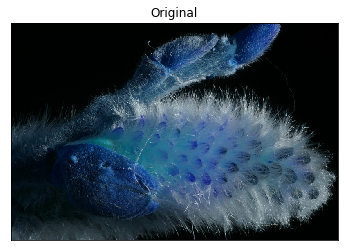

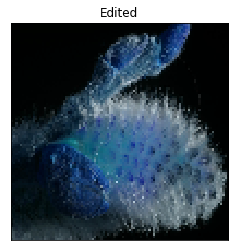

shape of X : (3474, 100, 100, 3)
shape of y : (3474,)


In [26]:
# load images from the dataset
print("Loading images ...")
images = loadImages()
print("Images loaded \n")

# sort images to be sure their are correctly associated to their data 
images = sort_images(images)

print("Processing images ...")    
sample, images = process_images(images)
print("Processing loaded \n")

# display an image to see the effect of the preprocessing
sample_edited = images[0]
print('Original size:', sample.shape)
print("New size:", sample_edited.shape)

display_one(sample)
display_one(sample_edited, 'Edited')

# create variables
X = np.array(images)
y = df[['Species']].values.ravel()

print("shape of X :", X.shape)
print("shape of y :", y.shape)

In [27]:
# Store variables to pass it to classifiers
preprocessed_images = (X, y)
%store preprocessed_images

del preprocessed_images

Stored 'preprocessed_images' (tuple)
